In [1]:
import sys
from shapely import wkt
import pandas as pd
from spopt.region.skater import Skater
from spopt.region import RegionKMeansHeuristic
import geopandas as gpd
import libpysal
from libpysal.examples import load_example
import numpy as np
from sklearn.metrics import pairwise as skm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 9]
import warnings
warnings.filterwarnings('ignore')

In [2]:
illinois = gpd.read_file('../data_misc/IL_Shapefiles/IL_BNDY_County_Py.shp')
illinois.sort_values(by='COUNTY_NAM', inplace=True)
illinois

,COUNTY_NAM,CO_FIPS,geometry
13,ADAMS,1,"POLYGON ((-91.50534 40.20028, -91.49184 40.200..."
61,ALEXANDER,3,"POLYGON ((-89.48603 37.33453, -89.47082 37.334..."
91,BOND,5,"POLYGON ((-89.25026 39.02822, -89.25025 39.013..."
1,BOONE,7,"POLYGON ((-88.70742 42.49351, -88.70740 42.493..."
39,BROWN,9,"POLYGON ((-90.62494 40.02607, -90.62491 40.026..."
...,...,...,...
63,WHITESIDE,195,"POLYGON ((-90.15197 41.92903, -90.13285 41.929..."
3,WILL,197,"POLYGON ((-88.26146 41.72439, -88.26146 41.724..."
70,WILLIAMSON,199,"POLYGON ((-89.15102 37.86180, -89.15021 37.861..."
67,WINNEBAGO,201,"POLYGON ((-88.94032 42.49504, -88.94034 42.492..."


In [3]:
wnd = pd.read_csv('average_wind_il_80m.csv')
wnd.sort_values(by='county', inplace=True)
sol = pd.read_csv('average_ghi_il.csv')
sol['ghi_converted'] = sol.avg_ghi*8760/(365*1000)
sol.sort_values(by='county', inplace=True)

In [4]:
# illinois['ghi_converted'] = df['ghi_converted']
illinois['avg_ghi'] = sol.avg_ghi
illinois['ghi_converted'] = illinois.avg_ghi*8760/(365*1000)
illinois['avg_wind'] = wnd.avg_wind
illinois

,COUNTY_NAM,CO_FIPS,geometry,avg_ghi,ghi_converted,avg_wind
13,ADAMS,1,"POLYGON ((-91.50534 40.20028, -91.49184 40.200...",167.923059,4.030153,7.101785
61,ALEXANDER,3,"POLYGON ((-89.48603 37.33453, -89.47082 37.334...",175.216781,4.205203,6.274413
91,BOND,5,"POLYGON ((-89.25026 39.02822, -89.25025 39.013...",169.119977,4.058879,6.480251
1,BOONE,7,"POLYGON ((-88.70742 42.49351, -88.70740 42.493...",157.595034,3.782281,6.650842
39,BROWN,9,"POLYGON ((-90.62494 40.02607, -90.62491 40.026...",168.846518,4.052316,6.992013
...,...,...,...,...,...,...
63,WHITESIDE,195,"POLYGON ((-90.15197 41.92903, -90.13285 41.929...",161.754281,3.882103,6.511824
3,WILL,197,"POLYGON ((-88.26146 41.72439, -88.26146 41.724...",157.686358,3.784473,6.861722
70,WILLIAMSON,199,"POLYGON ((-89.15102 37.86180, -89.15021 37.861...",171.975342,4.127408,6.301771
67,WINNEBAGO,201,"POLYGON ((-88.94032 42.49504, -88.94034 42.492...",158.400913,3.801622,6.714002


In [5]:
il_copy = illinois.copy()
il_copy = il_copy.to_crs(epsg=6933)
print(il_copy.crs)
il_copy['area'] = il_copy.geometry.area/1e6
il_copy.head(2)

epsg:6933


,COUNTY_NAM,CO_FIPS,geometry,avg_ghi,ghi_converted,avg_wind,area
13,ADAMS,1,"POLYGON ((-8829010.160 4726737.143, -8827706.8...",167.923059,4.030153,7.101785,2256.279362
61,ALEXANDER,3,"POLYGON ((-8634173.880 4440214.743, -8632706.6...",175.216781,4.205203,6.274413,655.896837


In [6]:
illinois['county_area'] = il_copy.area.values/1e6
illinois.head(5)

,COUNTY_NAM,CO_FIPS,geometry,avg_ghi,ghi_converted,avg_wind,county_area
13,ADAMS,1,"POLYGON ((-91.50534 40.20028, -91.49184 40.200...",167.923059,4.030153,7.101785,2256.279362
61,ALEXANDER,3,"POLYGON ((-89.48603 37.33453, -89.47082 37.334...",175.216781,4.205203,6.274413,655.896837
91,BOND,5,"POLYGON ((-89.25026 39.02822, -89.25025 39.013...",169.119977,4.058879,6.480251,991.535084
1,BOONE,7,"POLYGON ((-88.70742 42.49351, -88.70740 42.493...",157.595034,3.782281,6.650842,730.480700
39,BROWN,9,"POLYGON ((-90.62494 40.02607, -90.62491 40.026...",168.846518,4.052316,6.992013,795.716533


In [7]:
pop = pd.read_csv('il_county_pop.csv', usecols=['County','Population']).sort_values(by='County')
pop

,County,Population
22,Adams County,65737
95,Alexander County,5240
63,Bond County,16725
24,Boone County,53448
92,Brown County,6244
...,...,...
23,Whiteside County,55691
3,Will County,696355
21,Williamson County,67153
6,Winnebago County,285350


In [8]:
illinois['population'] = pop.Population.values
illinois.head(2)

,COUNTY_NAM,CO_FIPS,geometry,avg_ghi,ghi_converted,avg_wind,county_area,population
13,ADAMS,1,"POLYGON ((-91.50534 40.20028, -91.49184 40.200...",167.923059,4.030153,7.101785,2256.279362,65737
61,ALEXANDER,3,"POLYGON ((-89.48603 37.33453, -89.47082 37.334...",175.216781,4.205203,6.274413,655.896837,5240


In [9]:
illinois['pop_dens'] = np.divide(illinois.population, illinois.county_area)
illinois.head(2)

,COUNTY_NAM,CO_FIPS,geometry,avg_ghi,ghi_converted,avg_wind,county_area,population,pop_dens
13,ADAMS,1,"POLYGON ((-91.50534 40.20028, -91.49184 40.200...",167.923059,4.030153,7.101785,2256.279362,65737,29.135133
61,ALEXANDER,3,"POLYGON ((-89.48603 37.33453, -89.47082 37.334...",175.216781,4.205203,6.274413,655.896837,5240,7.989061


In [10]:
illinois.to_file('il_shapefiles/illinois_average_resource.shp')

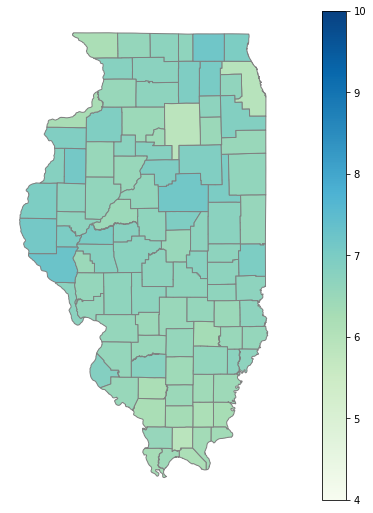

In [11]:
ax = illinois.plot(column='avg_wind', cmap='GnBu', edgecolor='grey', vmin=4.0, vmax=10.0,legend=True)
ax.set_axis_off()

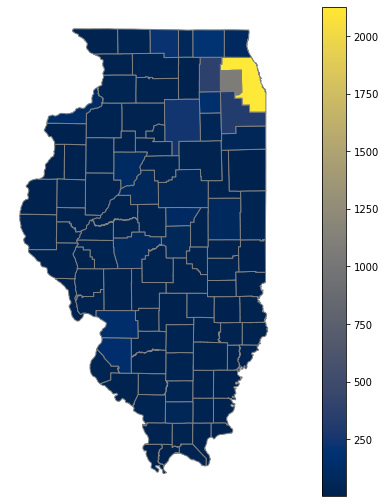

In [12]:
ax = illinois.plot(column='pop_dens', cmap='cividis', edgecolor='grey',legend=True)
ax.set_axis_off()

# The Skater Algorithm

Example from documentation is [here](https://pysal.org/spopt/notebooks/skater.html).

SKATER = "Spatial 'K'luster Analysis by Tree Edge Removal"

In [13]:
attrs_name = ['avg_wind']
w = libpysal.weights.Queen.from_dataframe(illinois)
n_clusters = 5
floor = 5
trace = False
islands = 'increase'
spanning_forest_kwds = dict(dissimilarity=skm.manhattan_distances, affinity=None, reduction=np.sum, center=np.mean)
model = Skater(illinois, w, attrs_name, n_clusters, floor, trace, islands, spanning_forest_kwds)
model.solve()

In [14]:
illinois['skater_new'] = model.labels_
illinois['number'] = 1
illinois[['skater_new','number', 'avg_wind']].groupby(by='skater_new').mean()

,number,avg_wind
skater_new,,
0,1.0,7.008413
1,1.0,6.300845
2,1.0,6.644242
3,1.0,6.294163
4,1.0,6.953545


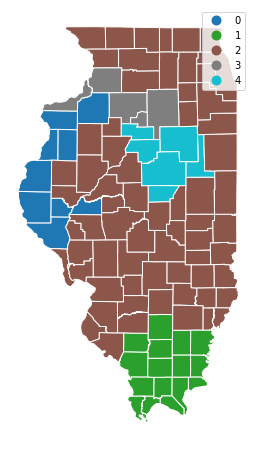

In [15]:
ax = illinois.plot(column='skater_new', categorical=True, figsize=(12,8), edgecolor='w', legend=True)
ax.set_axis_off()

In [16]:
attrs_name = ['avg_wind', 'pop_dens']
w = libpysal.weights.Queen.from_dataframe(illinois)
n_clusters = 5
floor = 5
trace = False
islands = 'increase'
spanning_forest_kwds = dict(dissimilarity=skm.manhattan_distances, affinity=None, reduction=np.sum, center=np.mean)
model = Skater(illinois, w, attrs_name, n_clusters, floor, trace, islands, spanning_forest_kwds)
model.solve()

In [20]:
illinois['skater_new'] = model.labels_
illinois['number'] = 1
illinois[['skater_new',
          'number', 
          'avg_wind', 
          'pop_dens']].groupby(by='skater_new').mean().sort_values(by='pop_dens', ascending=False)

,number,avg_wind,pop_dens
skater_new,,,
4,1.0,6.506105,715.602403
3,1.0,6.746217,82.069174
1,1.0,6.656074,80.944204
0,1.0,6.602409,20.419666
2,1.0,6.701582,20.180477


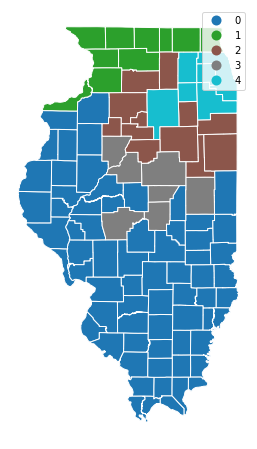

In [21]:
ax = illinois.plot(column='skater_new', categorical=True, figsize=(12,8), edgecolor='w', legend=True)
ax.set_axis_off()

In [22]:
attrs_name = ['ghi_converted']
w_q = libpysal.weights.Queen.from_dataframe(illinois)
n_clusters = 5
floor = 5
trace = False
islands = 'increase'
spanning_forest_kwds = dict(dissimilarity=skm.manhattan_distances, affinity=None, reduction=np.sum, center=np.mean)
model = Skater(illinois, w_q, attrs_name, n_clusters, floor, trace, islands, spanning_forest_kwds)
model.solve()
illinois['skater_new'] = model.labels_
illinois['number'] = 1
illinois[['skater_new','number','ghi_converted']].groupby(by='skater_new').mean()

,number,ghi_converted
skater_new,,
0,1.0,4.045564
1,1.0,4.135265
2,1.0,3.796057
3,1.0,3.984261
4,1.0,3.891812


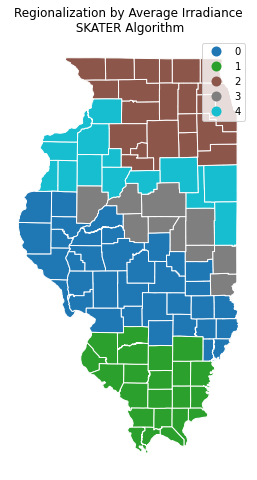

In [23]:
ax = illinois.plot(column='skater_new', categorical=True, figsize=(12,8), edgecolor='w', legend=True)
ax.set_title('Regionalization by Average Irradiance\n SKATER Algorithm')
ax.set_axis_off()

In [24]:
attrs_name = ['ghi_converted','avg_wind']
w = libpysal.weights.Queen.from_dataframe(illinois)
n_clusters = 5
floor = 5
trace = False
islands = 'increase'
spanning_forest_kwds = dict(dissimilarity=skm.manhattan_distances, affinity=None, reduction=np.sum, center=np.mean)
model = Skater(illinois, w, attrs_name, n_clusters, floor, trace, islands, spanning_forest_kwds)
model.solve()
illinois['skater_new'] = model.labels_
illinois['number'] = 1
illinois[['skater_new','number']].groupby(by='skater_new').count()

,number
skater_new,
0,31
1,14
2,23
3,24
4,10


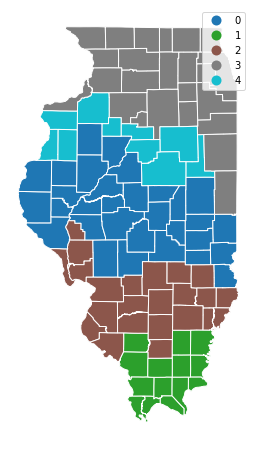

In [25]:
ax = illinois.plot(column='skater_new', categorical=True, figsize=(12,8), edgecolor='w', legend=True)
ax.set_axis_off()

# Regional K-Means Algorithm

Example from documentation is available [here](https://pysal.org/spopt/notebooks/reg-k-means.html).

In [27]:
RANDOM_SEED = 12345

In [44]:
attr_cols = ['avg_wind', 'pop_dens']
N_regions = 5
np.random.seed(RANDOM_SEED)
model = RegionKMeansHeuristic(illinois[attr_cols].values, N_regions, w)
model.solve()

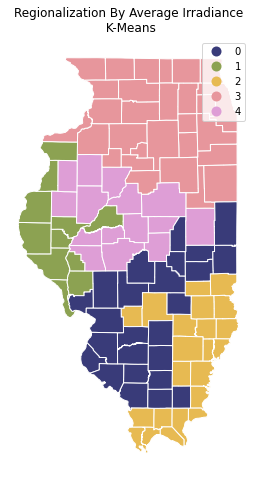

In [45]:
illinois["reg_k_mean"] = model.labels_
ax = illinois.plot(
    column="reg_k_mean",
    categorical=True,
    cmap="tab20b",
#     cmap="viridis",
    figsize=(12,8),
    legend=True,
    edgecolor="w")
ax.set_title('Regionalization By Average Irradiance\n K-Means')
ax.set_axis_off()

In [46]:
illinois[['reg_k_mean', 
          'avg_wind', 
          'ghi_converted',
          'pop_dens']].groupby(by='reg_k_mean').mean().sort_values(by='pop_dens', ascending=False)

,avg_wind,ghi_converted,pop_dens
reg_k_mean,,,
3,6.652879,3.819086,185.113420
4,6.763366,3.985348,47.573632
0,6.574220,4.064357,33.444637
2,6.449641,4.104248,11.990043
1,6.815427,4.016331,9.639407


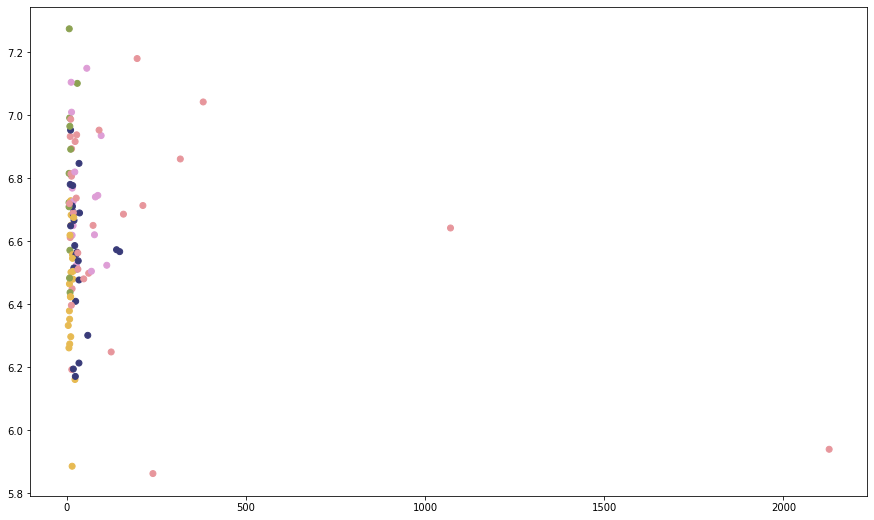

In [47]:
fig, ax = plt.subplots()
ax.scatter(illinois['pop_dens'], illinois['avg_wind'], c=illinois['reg_k_mean'], cmap='tab20b')

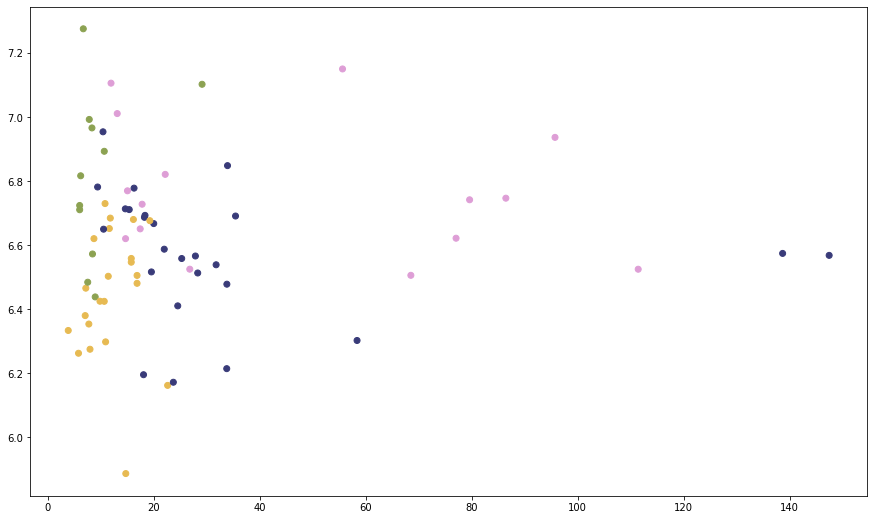

In [52]:
fig, ax = plt.subplots()
subset = illinois[illinois['reg_k_mean'] != 3]
ax.scatter(subset['pop_dens'], subset['avg_wind'], c=subset['reg_k_mean'], cmap='tab20b')